# Detecting Art Forgeries Using Machine Learning
Classifying craquelure (cracks due to old age) patterns in classical oil paintings

## Table of Contents
1. <a href ='#goal'>Problem Statement</a>
2. <a href='#terms'>Key Terminology</a>
3. <a href='#datasources'>Data Sources</a>
4. <a href='#EDA'>Exploratory Data Analysis/Image Preprocessing</a>
5. <a href='#models'>Image Classification Using CNN</a>
 1. <a href='#model1'>Model on Greyscale Images</a> 
 2. <a href='#model2'>Model on Color Images</a>
 3. <a href='#model3'>Model on Black and White Images</a>
6. <a href='#findings'>Findings</a>
7. <a href='#recs'>Next Steps</a>

In [4]:
# Import libraries & set defaults
import zipfile
import boto3
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import cv2
from keras import models, layers 
from keras.optimizers import Adam
from keras.callbacks import callbacks
from keras.models import load_model
np.random.seed(123)

Using TensorFlow backend.


<a id='goal'></a>
## Problem Statement

Art forgery has always been a problem that costs exorbitant amounts of money to art collectors and institutes like museums. Until very recently, art forgery detection has depended on unreliable, expensive and time-consuming technology and human expertise. 

However, over the past few years, machine learning experts have been exploring ways to simplify this process by classifying line strokes ad brush strokes by specific artists.

This project aims to contribute to the efforts in art forgery detection by classifying patterns in craquelure (cracks due to old age) by region in classical oil paintings. Oil paintings have different craquelure patterns depending on the time period and region they were created. Being able to classify when and/or where a painting is or is not from could add valuable information to determining whether a piece of work is authentic or a fake/forgery.

Due to the time constraints and limited resources, this project specifically looked at:

* 17th century
* Oil on canvas
* Dutch vs. Flemish paintings

<a id='terms'></a>
## Key Terminology

- **Craquelure**: cracks in paintings due to old age (different from cracks due to drying)
- **Flemish**: of or relating to Flanders, the Flemish Region of Belgium (northern Belgium)

<a id='datasources'></a>
## Data Sources

### The National Gallery of Art
(https://www.nga.gov/collection/collection-search.html)

- Full paintings from which craquelure images were extracted are in data/Full Paintings folder in this repo (the actual high resolution images are on the National Gallery of Art website above)
- Craquelure images used for modeling are available for download as a zipfile in the AWS S3 bucket: [art.forgery.capstone.project](https://s3.console.aws.amazon.com/s3/buckets/art.forgery.capstone.project/?region=us-east-1&tab=overview)

In [24]:
%run py_files/get_data

In [26]:
get_zipfile('art.forgery.capstone.project', 'Cracks.zip', 'data/Cracks.zip')
unzip('data/Cracks.zip')

<a id='EDA'></a>
## Exploratory Data Analysis / Image Preprocessing

In [18]:
%run py_files/eda

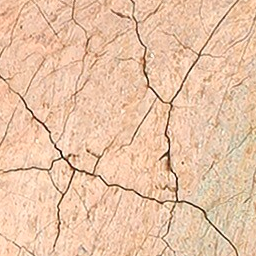

In [3]:
# Looking at a sample original/color image
load_img('sample_cracks_eda/Screen Shot 2020-01-09 at 1.02.27 PM.png')

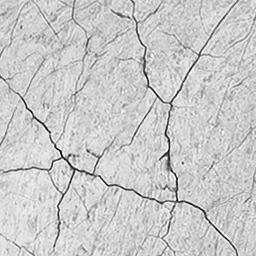

In [28]:
# Looking at a sample grayscaled image
load_img('sample_cracks_eda/Screen Shot 2020-01-09 at 1.02.27 PM.png', grayscale=True)

In [ ]:
## To save grayscale image and open image in separate window
# grayscale('sample_cracks_eda/Screen Shot 2020-01-09 at 1.02.27 PM.png')

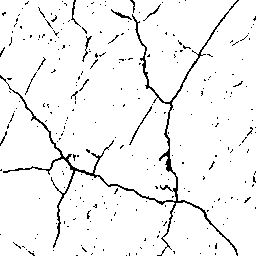

In [12]:
# Looking at a sample black & white image - may need to change threshold number depending on input image
bw_image = binarize_image(img_path='sample_cracks_eda/Screen Shot 2020-01-09 at 1.02.27 PM.png', threshold=155)
Image.fromarray(bw_image)

In [13]:
## To save b&w image
# bwimage = Image.fromarray(data)
# bwimage.save('insert_new_file_name')

In [22]:
## To invert b&w images that have black background and white lines gathered in a folder/directory
# invert_image('insert_directory_path')

<a id='models'></a>
## Image Classification Using CNN

<a id='model1'></a>
### 1) Model on Grayscale Images

In [5]:
# Directory path
train_data_dir = 'data/Cracks/train'
test_data_dir = 'data/Cracks/test'

# Get all the data in the directory data/test and grayscale
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=463, color_mode='grayscale')

# Get all the data in the directory data/train and grayscale
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=1806, color_mode='grayscale')

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 463 images belonging to 2 classes.
Found 1806 images belonging to 2 classes.


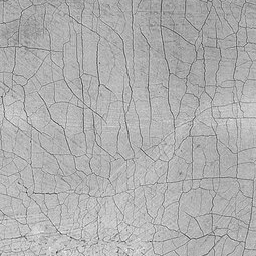

In [6]:
# Previewing an image for checking
array_to_img(train_images[15])

In [7]:
# Checking shape of data
print('train data shape:', np.shape(train_images), np.shape(train_labels))
print('test data shape:', np.shape(test_images), np.shape(test_labels))

train data shape: (1806, 256, 256, 1) (1806, 2)
test data shape: (463, 256, 256, 1) (463, 2)


In [8]:
# Unrowing/reshaping
train_img = train_images.reshape(train_images.shape[0], -1)
print('train_img:', np.shape(train_img))

test_img = test_images.reshape(test_images.shape[0], -1)
print('test_img:', np.shape(test_img))

train_img: (1806, 65536)
test_img: (463, 65536)


In [9]:
# Looking at the labels
train_labels

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [38]:
# Checking classes
train_generator.class_indices

{'Dutch': 0, 'Flemish': 1}

In [11]:
# Transposing the labels
train_y = np.reshape(train_labels[:,0], (1806,1))
print('train labels final:', np.shape(train_y))

test_y = np.reshape(test_labels[:,0], (463,1))
print('test labels final:', np.shape(test_y))

train labels final: (1806, 1)
test labels final: (463, 1)


In [12]:
# Grayscale Model 1
np.random.seed(123)
gr_model1 = models.Sequential()
gr_model1.add(layers.Conv2D(filters=10, kernel_size=10, strides=2, activation='relu',
                        input_shape=(256, 256,  1)))
gr_model1.add(layers.MaxPooling2D((10, 10)))

gr_model1.add(layers.Flatten())
gr_model1.add(layers.Dense(20, activation='relu'))
gr_model1.add(layers.Dense(100, activation='relu'))
gr_model1.add(layers.Dense(200, activation='relu'))
gr_model1.add(layers.Dense(1, activation='sigmoid'))

In [14]:
opt = Adam(lr=0.00001)

gr_model1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

gr_history_1 = gr_model1.fit(train_images,
                    train_y,
                    epochs=1200,
                    batch_size=32,
                    validation_split=0.3)

In [ ]:
# Saving grayscale model to 'models' folder
gr_model1.save('models/grayscale_model_1.h5')

In [15]:
# Testing grayscale_model_1
grayscale_model_1 = load_model('models/grayscale_model_1.h5')
grayscale_model_1.evaluate(x=test_images, y=test_y)

463/463 [==============================] - 1s 3ms/step


[4.575488138919773, 0.6544276475906372]

<a id='model2'></a>
### 2) Model on Color Images

In [43]:
# Directory path
train_data_dir = 'data/Cracks/train'
test_data_dir = 'data/Cracks/test'

# Get all the data in the directory data/validation, and reshape them
test_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=463)

# Get all the data in the directory data/train, and reshape them
train_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=1839)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 463 images belonging to 2 classes.
Found 1806 images belonging to 2 classes.


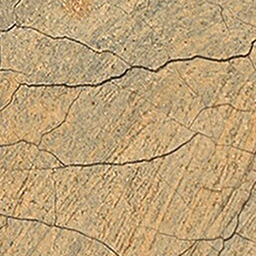

In [44]:
# Previewing an image for checking
array_to_img(train_images[15])

In [45]:
# Checking shape of data
print('train data shape:', np.shape(train_images), np.shape(train_labels))
print('test data shape:', np.shape(test_images), np.shape(test_labels))

train data shape: (1806, 256, 256, 3) (1806, 2)
test data shape: (463, 256, 256, 3) (463, 2)


In [46]:
# Unrowing/reshaping
train_img = train_images.reshape(train_images.shape[0], -1)
print('train_img:', np.shape(train_img))

test_img = test_images.reshape(test_images.shape[0], -1)
print('test_img:', np.shape(test_img))

train_img: (1806, 196608)
test_img: (463, 196608)


In [47]:
# Looking at the labels
train_labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [48]:
# Checking classes
train_generator.class_indices

{'Dutch': 0, 'Flemish': 1}

In [49]:
# Transposing the labels
train_y = np.reshape(train_labels[:,0], (1806,1))
print('train labels final:', np.shape(train_y))

test_y = np.reshape(test_labels[:,0], (463,1))
print('test labels final:', np.shape(test_y))

train labels final: (1806, 1)
test labels final: (463, 1)


In [50]:
np.random.seed(123)
cl_model1 = models.Sequential()
cl_model1.add(layers.Conv2D(filters=10, kernel_size=10, strides=2, activation='relu',
                        input_shape=(256, 256,  3)))
cl_model1.add(layers.MaxPooling2D((10, 10)))

cl_model1.add(layers.Flatten())
cl_model1.add(layers.Dense(20, activation='relu'))
cl_model1.add(layers.Dense(100, activation='relu'))
cl_model1.add(layers.Dense(200, activation='relu'))
cl_model1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
opt = Adam(lr=0.00001)
cl_model1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_1 = cl_model1.fit(train_images,
                    train_y,
                    epochs=1000,
                    batch_size=16,
                    validation_split=0.3)

In [ ]:
# Saving color model to 'models' folder
cl_model1.save('models/color_model_1.h5')

In [52]:
# Testing color_model_1
color_model_1 = load_model('models/color_model_1.h5')
color_model_1.evaluate(x=test_images, y=test_y)

463/463 [==============================] - 4s 9ms/step


[0.7403752895204861, 0.7883369326591492]

<a id='model3'></a>
### 3) Model on Black and White Images

In [24]:
# Directory path
train_data_dir = 'data/bwcracks/train'
test_data_dir = 'data/bwcracks/test'

# Get all the data in the directory data/validation, and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=463)

# Get all the data in the directory data/train, and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=1814)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 0 images belonging to 0 classes.
Found 1806 images belonging to 2 classes.


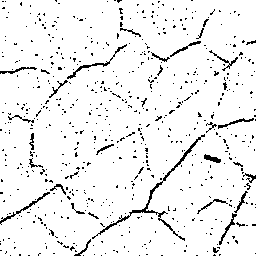

In [25]:
# Previewing an image
array_to_img(train_images[15])

In [26]:
train_images.shape

(1806, 256, 256, 3)

In [27]:
# Checking shape of data
print('train data shape:', np.shape(train_images), np.shape(train_labels))
print('test data shape:', np.shape(test_images), np.shape(test_labels))

train data shape: (1806, 256, 256, 3) (1806, 2)
test data shape: (0, 256, 256, 3) (0, 0)


In [28]:
# Unrowing/reshaping
train_img = train_images.reshape(train_images.shape[0], -1)
print('train_img:', np.shape(train_img))

# test_img = test_images.reshape(test_images.shape[0], -1)
# print('test_img:', np.shape(test_img))

train_img: (1806, 196608)


In [29]:
# Looking at the labels
train_labels

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [39]:
# Checking classes
train_generator.class_indices

{'Dutch': 0, 'Flemish': 1}

In [31]:
# Transposing the labels
train_y = np.reshape(train_labels[:,0], (1806,1))
print('train labels final:', np.shape(train_y))

# test_y = np.reshape(test_labels[:,0], (463,1))
# print('test labels final:', np.shape(test_y))

train labels final: (1806, 1)


In [32]:
np.random.seed(123)
bw_model1 = models.Sequential()
bw_model1.add(layers.Conv2D(filters=10, kernel_size=10, strides=2, activation='relu',
                        input_shape=(256, 256,  3)))
bw_model1.add(layers.MaxPooling2D((10, 10)))

bw_model1.add(layers.Flatten())
bw_model1.add(layers.Dense(20, activation='relu'))
bw_model1.add(layers.Dense(100, activation='relu'))
bw_model1.add(layers.Dense(200, activation='relu'))
bw_model1.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
opt = Adam(lr=0.00001)
stopping = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=25)

bw_model1.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_2 = bw_model1.fit(train_images,
                    train_y,
                    epochs=500,
                    batch_size=16,
                    callbacks=[stopping],
                    validation_split=0.3)

In [ ]:
# Saving black and white model to 'models' folder
bw_model1.save('models/bw_model_1.h5')

In [41]:
# Testing bw_model_1
bw_model_1 = load_model('models/bw_model_1.h5')
bw_model_1.evaluate(x=train_images, y=train_y)

1806/1806 [==============================] - 15s 8ms/step


[0.5505943048832028, 0.7347729802131653]

<a id='findings'></a>
## Findings

Unsurprisingly, the model based on color images performed the best. This mostly likely due to bias based on color/pixel values in the images, many of which were sampled from the same whole painting. Instead of recognizing patterns in the crack lines, the algorithm may have been detecting patterns of color.

The second best was the grayscale model, again, probably because it was biased by the grayness, since even grayscaled images have different shades of gray based on what the original color was.

Unfortunately, the black and white model, which is the most standardized one, came in third place. However, this may be because there was a lot of noise in the images (black dots that do not have to do with the actual crack lines).

<a id='recs'></a>
## Limitations & Future Directions

This project was based on a very small and biased dataset. The models could be greatly improved by access to a larger number of high resolution collection of artworks from around the world.

The entire process of data collection for the project was done manually by cropping, therefore, some of the craquelure images may have been more zoomed in than others - in other words, not standardized. A much better dataset could be created by code that automates the collection and preprocessing process. Models built on such data would be much higher quality and reliable.

The models could also be upgraded to classify more regions, and even by centuries.